# Часть 1: Прототипирование и выбор модели

## Построение базового пайплайна, логирование в MLFlow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import mlflow

In [2]:
df = pd.read_parquet('../assets/taxi/fhvhv_tripdata_2019-02.parquet')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')

demand_df = df.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='trip_count')
del df

/tmp/ipykernel_250653/2492409017.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')


In [3]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['hour'] = X_transformed['pickup_hour'].dt.hour
        X_transformed['dayofweek'] = X_transformed['pickup_hour'].dt.dayofweek

        X_transformed['lag_1h'] = X_transformed.groupby('PULocationID')['trip_count'].shift(1)
        X_transformed['lag_24h'] = X_transformed.groupby('PULocationID')['trip_count'].shift(24)
        X_transformed['lag_168h'] = X_transformed.groupby('PULocationID')['trip_count'].shift(168)

        X_transformed['rolling_mean_24h'] = X_transformed.groupby('PULocationID')['trip_count'].shift(1).rolling(window=24).mean()
        
        X_transformed = X_transformed.drop('pickup_hour', axis=1)
        X_transformed = X_transformed.drop('trip_count', axis=1)
        return X_transformed

In [4]:
def train_test_split_time_series(data, date_column, test_size):
    data = data.sort_values(by=date_column)
    split_index = int(len(data) * (1 - test_size))
    train_df = data.iloc[:split_index]
    test_df = data.iloc[split_index:]
    return train_df, test_df

In [5]:
train_df, test_df = train_test_split_time_series(demand_df, 'pickup_hour', 0.3)

# Отделяем целевую переменную
y_train = train_df['trip_count']
y_test = test_df['trip_count']

# На вход пайплайна подаем DataFrame, где еще есть trip_count,
# так как FeatureEngineer использует его для создания лагов.
# Но из целевой переменной мы его уже отделили.
X_train = train_df
X_test = test_df

In [6]:
feature_engineer = FeatureEngineer()
imputer = SimpleImputer(strategy='constant', fill_value=0)
regressor = lgb.LGBMRegressor(random_state=42)

imputer.set_output(transform="pandas") 

model_pipeline = Pipeline([
    ('feature_engineering', feature_engineer),
    ('imputer', imputer),
    ('regressor', regressor)
])

In [7]:
print("--- Обучение пайплайна ---")

# Важный трюк: как передать `categorical_feature` в шаг 'regressor'
# Используем синтаксис `имя_шага__имя_параметра`
# Указываем индекс столбца, а не его имя, так как SimpleImputer удаляет имена.
fit_params = {
    'regressor__categorical_feature': [0] 
}

model_pipeline.fit(X_train, y_train, **fit_params)
print("Готово.")

print("\n--- Оценка модели ---")
predictions = model_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

--- Обучение пайплайна ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 118509, number of used features: 7
[LightGBM] [Info] Start training from score 117.281439
Готово.

--- Оценка модели ---
MAE: 15.06
RMSE: 27.45
R2 Score: 0.9635


In [8]:
# Зададим параметры нашей модели в одном месте
# Это удобно для логирования и дальнейшего тюнинга
lgbm_params = {
    'random_state': 42,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31
}

model_pipeline.set_params(regressor__random_state=lgbm_params['random_state'],
                           regressor__n_estimators=lgbm_params['n_estimators'],
                           regressor__learning_rate=lgbm_params['learning_rate'],
                           regressor__num_leaves=lgbm_params['num_leaves'])


mlflow.set_tracking_uri("sqlite:///mlflow.db")
# --- НАЧАЛО БЛОКА MLFLOW ---
mlflow.set_experiment("NYC Taxi Demand Forecasting")

with mlflow.start_run(run_name="LGBM_Pipeline_Baseline_v2"):
    
    print("--- Логирование параметров в MLflow ---")
    mlflow.log_params(lgbm_params)
    
    print("--- Обучение пайплайна ---")
    fit_params = {
        'regressor__categorical_feature': [0] 
    }
    model_pipeline.fit(X_train, y_train, **fit_params)
    print("Готово.")

    print("\n--- Оценка модели и логирование метрик ---")
    predictions = model_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

    mlflow.log_metrics({"mae": mae, "rmse": rmse, "r2_score": r2})

    print("\n--- Сохранение модели в MLflow ---")
    
    # Создаем пример входных данных для подписи
    # ВАЖНО: он должен быть таким, каким данные заходят в пайплайн
    input_example = X_train.head(5)

    mlflow.sklearn.log_model(
        sk_model=model_pipeline,
        artifact_path="demand_forecasting_pipeline",
        registered_model_name="LGBM-Demand-Forecaster",
        input_example=input_example
    )
    
    print("\nЭксперимент успешно залогирован в MLflow!")

2025/11/09 15:53:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/09 15:53:19 INFO mlflow.store.db.utils: Updating database tables
2025-11-09 15:53:19 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-09 15:53:19 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-09 15:53:19 INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
2025-11-09 15:53:19 INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025-11-09 15:53:19 INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025-11-09 15:53:19 INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025-11-09 15:53:19 INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025-11-09 15:53:19 INFO  [alembic.runtime.mig

--- Логирование параметров в MLflow ---
--- Обучение пайплайна ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 118509, number of used features: 7
[LightGBM] [Info] Start training from score 117.281439


2025/11/09 15:53:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Готово.

--- Оценка модели и логирование метрик ---
MAE: 15.06
RMSE: 27.45
R2 Score: 0.9635

--- Сохранение модели в MLflow ---


/home/nockerox/Dev/bigdata/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/09 15:53:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/09 15:53:24 INFO mlflow.store.db.utils: C


Эксперимент успешно залогирован в MLflow!


Successfully registered model 'LGBM-Demand-Forecaster'.
Created version '1' of model 'LGBM-Demand-Forecaster'.


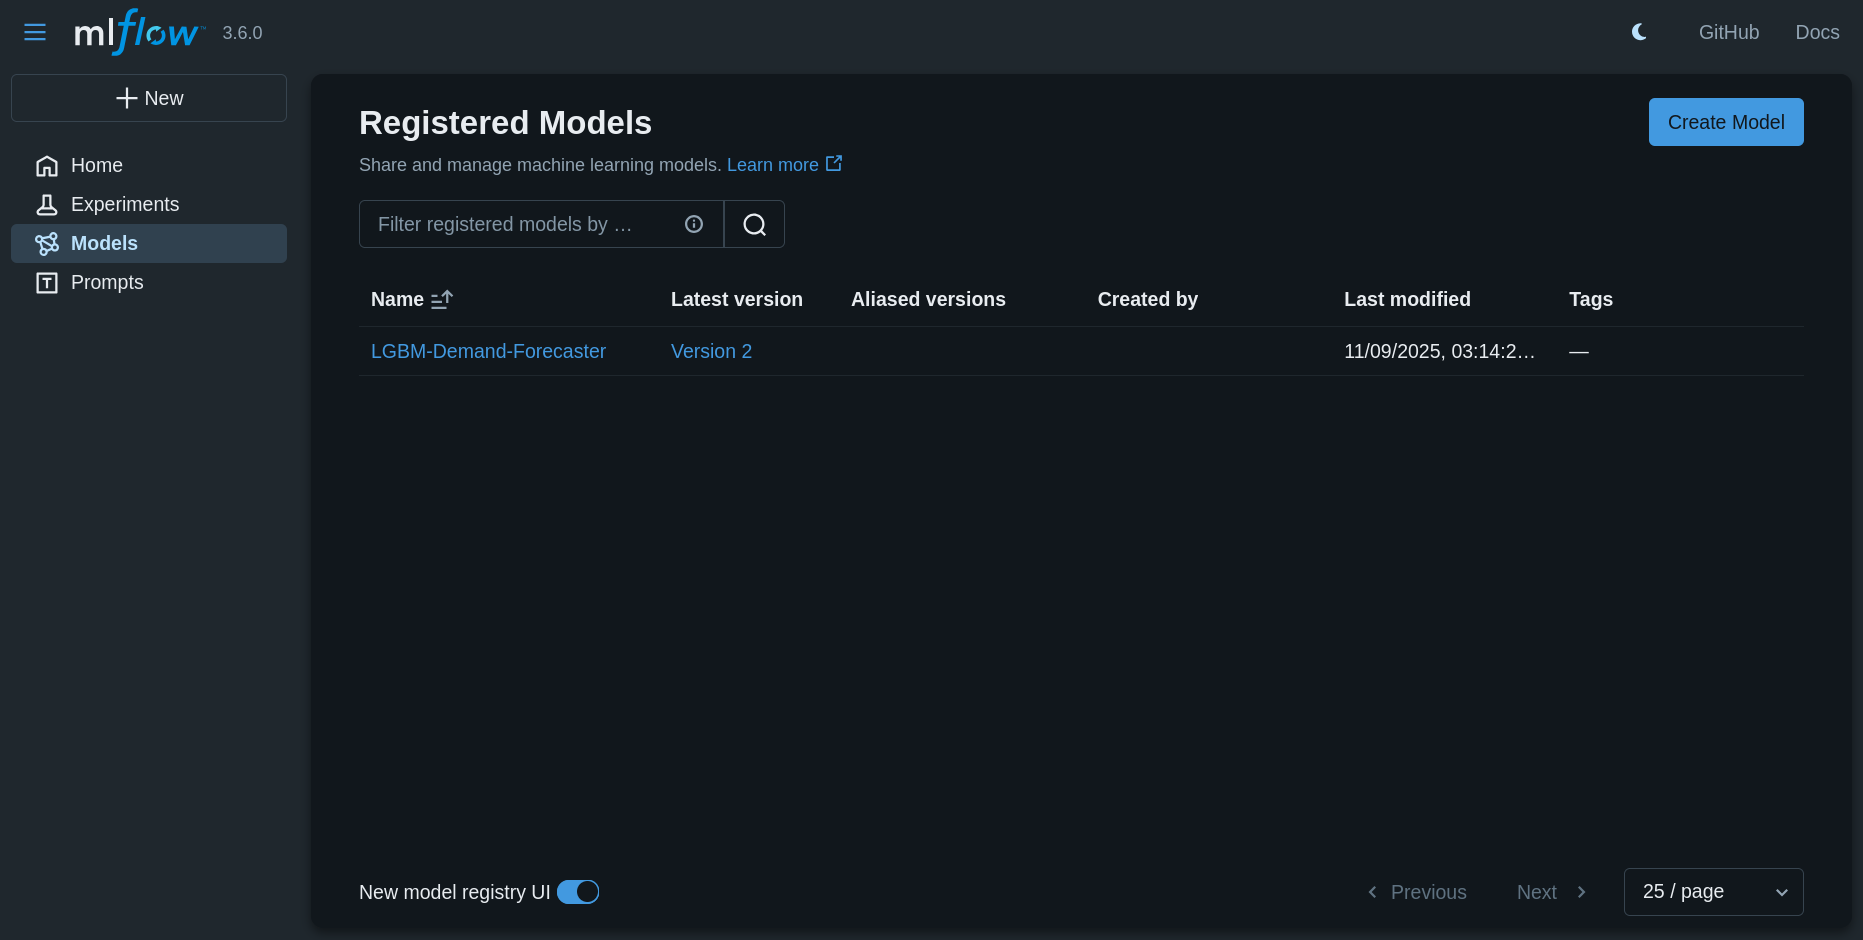